In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle
from tqdm import tqdm
from model import match_model

In [43]:
# Load data
processed_data = pd.read_csv('./final_data.csv', index_col='count')

training_data = processed_data.sample(frac=0.9, random_state=200)
test_data = processed_data.drop(training_data.index).sample(frac=1.0, random_state=203)

X_train_df = training_data.drop('winner', axis=1)
y_train_df = training_data.drop(X_train_df.columns, axis=1)

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy().flatten()

print(f"Training Data length: {len(training_data)}")
print(f"Test Data length: {len(test_data)}")
X_train_df

Training Data length: 413909
Test Data length: 45990


,wr delta,rating delta,pps delta,vs delta
count,,,,
123378,0.465225,0.522852,0.501910,0.537927
376917,0.419163,0.487488,0.500382,0.593085
277366,0.485922,0.623664,0.503438,0.585284
251779,0.468625,0.443679,0.510313,0.531275
350465,0.479748,0.461640,0.498090,0.541540
...,...,...,...,...
379926,0.421387,0.574602,0.505730,0.582601
217590,0.444649,0.567816,0.476700,0.540856
286460,0.465479,0.571988,0.491979,0.587309


In [44]:
def make_prediction(row, w, b):
    z = np.dot(row, w) + b
    return 1 / (1 + np.exp(-z))

In [45]:
def compute_loss(row, w, b, y):
    pred = make_prediction(row, w, b)
    return -y * (np.log(pred)) - (1-y) * (np.log(1-pred))

In [46]:
def compute_cost(X_data, w, b, y_data):
    m = X_data.shape[0]
    cost = 0
    for i in range(m):
        cost += compute_loss(X_data[i], w, b, y_data[i])
    cost /= m

    return cost

In [47]:
def compute_gradient(X_data, w, b, y_data):
    m,n = X_data.shape

    dj_dw = np.zeros((n,))
    dj_db = 0

    for i in range(m):
        err_i = make_prediction(X_data[i], w, b) - y_data[i]

        for j in range(n):
            dj_dw[j] += err_i * X_data[i,j]
        dj_db += err_i
    
    dj_dw /= m
    dj_db /= m

    return dj_dw, dj_db

In [48]:
def grad_desc(X_data, w, b, y_data, alpha, num_iters):
    cost_hist = []
    w_final = copy.deepcopy(w)
    b_final = b

    for i in tqdm(range(num_iters)):
        dj_dw, dj_db = compute_gradient(X_data, w_final, b_final, y_data)
        w_final -= alpha * dj_dw
        b_final -= alpha * dj_db
        
        cost_hist.append(compute_cost(X_data, w_final, b_final, y_data))

        if i % (num_iters // 10) == 0:
            print(f"Iteration {i:4d}: Cost {cost_hist[i]}")
    return w_final, b_final, cost_hist

In [49]:
m, n = X_train.shape
w_init = np.zeros((n,))
b_init = 0.
learning_rate = 1
iterations = 10000

w_fin, b_fin, cost_history = grad_desc(X_train, w_init, b_init, y_train, learning_rate, iterations)
print(f'Updated Parameters: w = {w_fin}, b = {b_fin}')

  0%|          | 1/10000 [00:03<9:28:59,  3.41s/it]

Iteration    0: Cost 0.6929993672038822


 10%|█         | 1001/10000 [42:22<6:18:43,  2.53s/it]

Iteration 1000: Cost 0.6447594303098639


 20%|██        | 2001/10000 [1:24:15<5:34:50,  2.51s/it]

Iteration 2000: Cost 0.6333074463376679


 30%|███       | 3001/10000 [2:06:24<4:57:15,  2.55s/it]

Iteration 3000: Cost 0.6293854736631337


 40%|████      | 4001/10000 [2:48:40<4:12:31,  2.53s/it]

Iteration 4000: Cost 0.6277304927600059


 50%|█████     | 5001/10000 [3:30:56<3:30:28,  2.53s/it]

Iteration 5000: Cost 0.6269252242050674


 60%|██████    | 6001/10000 [4:13:10<2:49:33,  2.54s/it]

Iteration 6000: Cost 0.6264879886837486


 70%|███████   | 7001/10000 [4:55:24<2:06:03,  2.52s/it]

Iteration 7000: Cost 0.6262286419951457


 80%|████████  | 8001/10000 [5:37:38<1:24:28,  2.54s/it]

Iteration 8000: Cost 0.6260634597271267


 90%|█████████ | 9001/10000 [6:19:52<41:53,  2.52s/it]  

Iteration 9000: Cost 0.625952180592113


100%|██████████| 10000/10000 [7:01:59<00:00,  2.53s/it]

Updated Parameters: w = [-4.28023939 -8.96972009  0.83964405 -6.67464904], b = 9.866971050519266


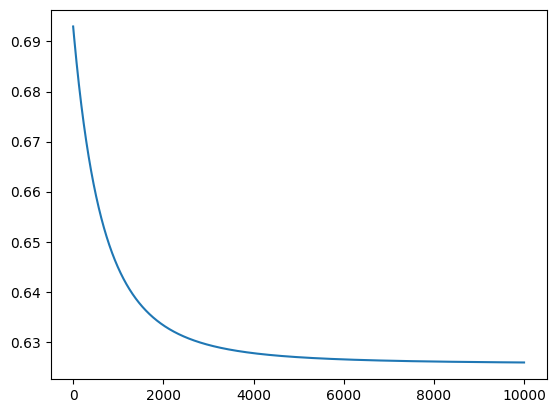

In [53]:
plt.plot(cost_history)

In [50]:
X_test_df = test_data.drop('winner', axis=1)
y_test_df = test_data.drop(X_test_df.columns, axis=1)

m = X_test_df.shape[0]
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy().flatten()

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
pred_arr = []
for i in range(m):
    pred = make_prediction(X_test[i], w_fin, b_fin)
    pred_arr.append(pred)
    if pred >= 0.5:
        pred = 1
    else:
        pred = 0
    if (pred == 1 and y_test[i] == 1):
        true_positive += 1
    elif (pred == 1 and y_test[i] == 0):
        false_positive += 1
    elif (pred == 0 and y_test[i] == 0):
        true_negative += 1
    else:
        false_negative += 1
print(f"True Positive: {true_positive}")
print(f"True Negative: {true_negative}")
print(f"False Positive: {false_positive}")
print(f"False Negative: {false_negative}")
print(f"Precision: {true_positive / (true_positive + false_positive)}")
print(f"Recall: {true_positive / (true_positive + false_negative)}")
print(f"F1 Score: {true_positive / (true_positive + 0.5*(false_positive + false_negative))}")



True Positive: 15159
True Negative: 15330
False Positive: 7754
False Negative: 7747
Precision: 0.6615894906821455
Recall: 0.6617916703047236
F1 Score: 0.6616905650494337


In [51]:
model = match_model(w_fin, b_fin)

with open ('match_predict_model.pkl', 'wb') as f:
    pickle.dump(model, f)